# Colegio de Postgraduados Campus Montecillo
## Posgrado en Socioeconomía, Estadística e Informática
## Cómputo Aplicado

## Identificación de enfermedades a partir del conjunto de imágenes utilizado

Por: Ulises Enrique Campos Ferreira

### LEER INDICACIONES

Este script corresponde a una modificación del script <u>4 Identificación de enfermedades.ipynb</u>, donde la modificación que se realizó fue en la función `predice`, aquí se incluyó lo obtenido del árbol de decisión del archivo <u>5 Árbol de decisión CART.ipynb</u>. 
No se tendrán modificaciones en las identificaciones de los frutos (Figura 3); es en el cuadro de salida, donse se agrega la clasificación predicha por el modelo.

### Importar las librerías necesarias 

In [1]:
import cv2 as cv
import pandas as pd
import pickle
import os
import numpy as np
import warnings
from PIL import Image

warnings.filterwarnings("ignore")

Debido a que es necesario utilizar una versión antigua de `scikit-learn == 0.21.3`, es necesario importar la librería `warnings`, para ignorar todas las advertencias que puedan aparecer. 

Para este código se crearon tres funciones necesarias, las cuales fueron <code>lee_etiquetas</code>, ```extension``` y ```predice```.

### Función <code> lee_etiquetas </code> 

In [2]:
def lee_etiquetas(ruta):
    '''
    Función que lee las etiquietas de identificación a partir de un archivo
    en formato .csv
    '''
    
    archivo = pd.read_csv(ruta)
    
    return archivo

head = lee_etiquetas("/Users/campos/Documents/COA 690/Segundo entrenamiento/Etiquetas prueba.csv")
head.head()

,Archivo,Clase
0,Fruto 1,A
1,Fruto 2,A
2,Fruto 3,A
3,Fruto 4,A
4,Fruto 5,A


Esta función solamente se encarga de leer un archivo .csv

Para el presente trabajo, como se utilizaron 90 imágenes, se creó un archivo donde solamente se incluye el nombre del archivo sin su extensión, además a la clase a la que pertenece, cada una de las clases contó con 30 imágenes.

### Función <code> extension </code> 

In [3]:
def extension (dataframe):
    '''
    Función que agregará la extensión ".jpg" a cada nombre de archivo
    a partir de un dataframe, obtenido de lee_etiquetas()
    '''
    for i in range (dataframe.shape[0]):
        nombre = dataframe.iloc[i]["Archivo"]
        archivo = nombre + ".jpg"
        
        dataframe = dataframe.replace([nombre], archivo)
    return dataframe

jpg = extension(head)
jpg.head()

,Archivo,Clase
0,Fruto 1.jpg,A
1,Fruto 2.jpg,A
2,Fruto 3.jpg,A
3,Fruto 4.jpg,A
4,Fruto 5.jpg,A


Con esta función solamente se agregará de manera iterativa la extensión .jpg a cada uno de los registros de la columna Archivo. 

### Función <code> predice </code> 

In [4]:
def predice(ruta_img, csv, opcion):
    #Se convierte a HSV
    
    os.chdir(ruta_img)
    
    nombre = []
    observado = []
    total_s = []
    total_r = []
    total_a = []
    p1 = []
    p2 = []
    p3 = []
    clase_s = []
    

    for i in range (csv.shape[0]):
        
        I=cv.imread(csv.iloc[i]["Archivo"])
        nombre.append(csv.iloc[i]["Archivo"])
        observado.append(csv.iloc[i]["Clase"])
        I_HSV=cv.cvtColor(I,cv.COLOR_BGR2HSV) #COLOR_BGR2HSV
        I_ExR=1.4*I[:,:,2]-I[:,:,1] #I_ExR=1.4*R-G
        #Se contruye la base datos a predecir
        tamaño=I.shape
        columnas=['H','S','V','ExR']
        #Se aplanan las imagenes HSV, RGB y ExR
        DB_RGB=pd.DataFrame(I.reshape(tamaño[0]*tamaño[1],tamaño[2]))
        DB_HSV=pd.DataFrame(I_HSV.reshape(tamaño[0]*tamaño[1],tamaño[2]))
        #DB_apredecir=pd.concat([DB_apredecir,DB_HSV],axis=1)
        DB_apredecir=DB_HSV
        DB_ExR=pd.DataFrame(I_ExR.reshape(tamaño[0]*tamaño[1],1))
        DB_apredecir=pd.concat([DB_apredecir,DB_ExR],axis=1)
        DB_apredecir.columns=columnas #Debido a que opencv lee las imagenes en BGR
        DB_apredecir['index1']= DB_apredecir.index
        DB_copy=DB_apredecir.copy()
        #Se eliminan las tripletas con valores cercano a 255,255,255 por ser parte del fondo

        namecol=['B','G','R']
        DB_RGB.columns=namecol
        indices=DB_RGB[(DB_RGB['B']<15)&(DB_RGB['G']<15)&(DB_RGB['R']<15)].index
        DB_copy=DB_copy.drop(indices,inplace=False)
        #Se carga el modelo entrenado
        #Se carga el modelo según la opción, 1 RF, 2 SVM y 3 MLP
        if opcion==1:
            modelo = pickle.load(open('/Users/campos/Documents/COA 690/Segundo entrenamiento/Modelos optimizados/RF_mejor_fold.pkl', 'rb'))
        elif opcion==2:
            modelo = pickle.load(open('/Users/campos/Documents/COA 690/Segundo entrenamiento/Modelos optimizados/SVM_mejor_fold.pkl', 'rb'))            
        elif opcion==3:
            modelo = pickle.load(open('/Users/campos/Documents/COA 690/Segundo entrenamiento/Modelos optimizados/MLP_mejor_fold.pkl', 'rb'))
        #Se extraen los valores predictoras de la imagen de entrada
        X=DB_copy[['H','S','V']].astype(int) #Entrada como data frame
        X=X.to_numpy() #Entrada como arreglo
    
        Y_predic = modelo.predict(X) #Se lleva acabo la prediccion para cada tripleta
        DF_ypredic=pd.DataFrame(Y_predic) #Se crea una base de datos de las salidas predichas
        DF_ypredic.columns=['Ypredict'] #Se define la columna
        #Se une la data frame de entrada con la dataframe que contiene las salidas predichas
        DB_copy=DB_copy.reset_index(drop=True, inplace=False) #Se resetea el index para concatenar las dos bases
        DF_nuevo=pd.concat([DB_copy, DF_ypredic],axis=1)
        #Se restablece el index para pode unir las tablas en la fila adecuada y no alterar la imagen original
        DF_nuevo=DF_nuevo.set_index('index1') 
        DF_nuevo=DF_nuevo.drop(columns=['H','S','V','ExR']) 
        DF_salida=pd.concat([DB_apredecir,DF_nuevo],axis=1)
        DF_salida2=DF_salida.drop(columns=['index1'])
        DF_salida2=DF_salida2.fillna(3)
        #Descomentar para armar la salida clasificada
        DF_salida3=DF_salida2.drop(columns=['H','S','V','ExR']) #Data frame para colorear las salidas clase1:rojo, clase2:amarillo, clase3:azul, clase4:verde
        DF_salida3.loc[DF_salida3['Ypredict'] == 0, 'R'] = 0
        DF_salida3.loc[DF_salida3['Ypredict'] == 0, 'G'] = 255
        DF_salida3.loc[DF_salida3['Ypredict'] == 0, 'B'] = 0
    
        DF_salida3.loc[DF_salida3['Ypredict'] == 1, 'R'] = 161
        DF_salida3.loc[DF_salida3['Ypredict'] == 1, 'G'] = 130
        DF_salida3.loc[DF_salida3['Ypredict'] == 1, 'B'] = 98
    
        DF_salida3.loc[DF_salida3['Ypredict'] == 2, 'R'] = 0
        DF_salida3.loc[DF_salida3['Ypredict'] == 2, 'G'] = 0
        DF_salida3.loc[DF_salida3['Ypredict'] == 2, 'B'] = 0
    
        DF_salida3.loc[DF_salida3['Ypredict'] == 3, 'R'] = 255
        DF_salida3.loc[DF_salida3['Ypredict'] == 3, 'G'] = 255
        DF_salida3.loc[DF_salida3['Ypredict'] == 3, 'B'] = 255
    
        DF_salida3=DF_salida3 #Se actualiza la dataframe 3
        DF_salida3=DF_salida3.drop(columns=['Ypredict']) #Se elimina la columna predicha y Exceso de rojo para poder armar la imagen BGR
        DF_salida3=DF_salida3.to_numpy()
        DF_salida3=DF_salida3.astype('u1').reshape((tamaño[0],tamaño[1],tamaño[2]))
        
        img_salida = np.reshape(DF_salida3, (256,256,3))
        imagen_salida = "Salida " + str(i + 1) + ".jpg"
        archivo_salida = Image.fromarray(DF_salida3)
        archivo_salida.save(imagen_salida)
    
        #Se contabilizan los pixeles para cada clase
        Total=len(DF_nuevo)
        Elementos=DF_nuevo['Ypredict'].value_counts()
        
        Elementos = Elementos.reindex([0, 1, 2], fill_value=0)
        
        total_s.append(Elementos[0])
        total_r.append(Elementos[1])
        total_a.append(Elementos[2])
        
        DF_resultados=pd.DataFrame(Elementos)

        #Se calcula la columna de porcentaje
        DF_resultados['Tasa Relativa']=DF_resultados['Ypredict']/Total
        
        #Mostrar las imagenes traslapadas
        image_mostrar= cv.addWeighted(src1=I, alpha=0.97, src2=DF_salida3, beta=0.35, gamma=0)

        #Tabla a retornar
        DF_exp=DF_resultados['Tasa Relativa']
        DF_exp=DF_exp.sort_index()
        DF_exp=pd.DataFrame(DF_exp)

        #Se rellenan las etiquetas
        Porciento1=round(100*DF_exp.iloc[0,0],2)
        p1.append(Porciento1)
        Porciento2=round(100*DF_exp.iloc[1,0],2)
        p2.append(Porciento2)
        Porciento3=round(100*DF_exp.iloc[2,0],2)
        p3.append(Porciento3)
                
        alto, ancho, canales=I.shape
        tam_string=str(alto)+'x'+str(ancho)+'x'+str(canales)

# Suponiendo que tienes los valores de las características necesarias
# Reglas de decisión obtenidas por el CART
        Sanos = Porciento1
        Roña = Porciento2
        Antracnosis = Porciento3
        
        # Reglas de decisión
        if Roña <= 16.79:
            if Roña <= 1.97:
                if Antracnosis <= 48.27:
                    if Sanos <= 98.12:
                        if Antracnosis <= 30.56:
                            if Antracnosis <= 28.07:
                                if Sanos <= 92.97:
                                    print('Fruto con antracnosis')
                                    decision = "A"
                                    clase_s.append(decision)
                                else:
                                    print('Fruto sano')
                                    decision = "S"
                                    clase_s.append(decision)
                            else:
                                print('Fruto sano')
                                decision = "S"
                                clase_s.append(decision)
                        else:
                            print('Fruto sano')
                            decision = "S"
                            clase_s.append(decision)
                    else:
                        print('Fruto sano')
                        decision = "S"
                        clase_s.append(decision)
                else:
                    print('Fruto con antracnosis')
                    decision = "A"
                    clase_s.append(decision)
            else:
                if Roña <= 5.98:
                    print('Fruto con antracnosis')
                    decision = "A"
                    clase_s.append(decision)
                else:
                    if Antracnosis <= 33.26:
                        print('Fruto con roña')
                        decision = "R"
                        clase_s.append(decision)
                    else:
                        print('Fruto con antracnosis')
                        decision = "A"
                        clase_s.append(decision)
        else:
            print('Fruto con roña')
            decision = "R"
            clase_s.append(decision)

    
        porcentajes = {'Archivo': nombre,
                       'Clase observada': observado,
                   'Total Sanos': total_s,
                   'Porcentaje S': p1,
                   'Total Ronia': total_r,
                   'Porcentaje R': p2,
                   'Total Antracnosis': total_a,
                   'Porcentaje A': p3,
                   'Clase predicha': clase_s}
        porcentajes_1 = pd.DataFrame(data = porcentajes)
            
    return porcentajes_1

Esta es una función más compleja que realiza diferentes procesos. Este apartado es una modificación del archivo `Image_Prediction`de <b>IDENTO</b>, donde una de las modificaciones más importantes fue la de hacer la clasificación de imágenes por lote, en lugar de hacerlo de manera individual. 

Esta función recibe tres parámetros: el directorio donde se encuentran las imágenes, el archivo .csv que contiene los datos de identificación, y el modelo de <i>machine learning</i> con el que se harán las predicciones.

En este trabajo se hizo una segmentación del fondo y el fruto para poder realizar las predicciones, como se muestra en la siguiente Figura:

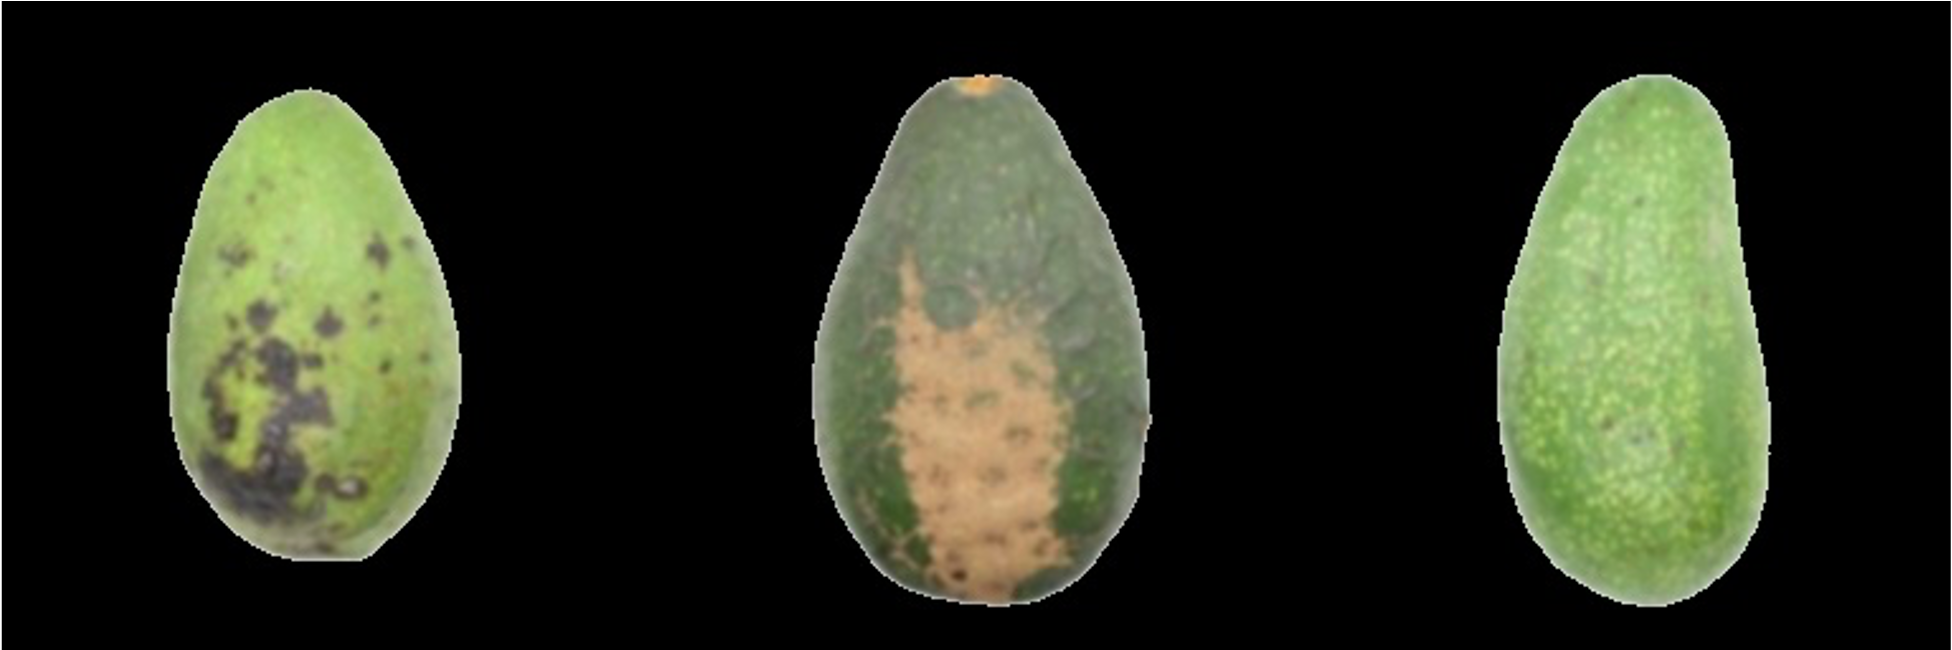 

## Figura 1. Imágenes segmentadas utilizadas para la predicción de los modelos 

Esto se aplicó a las 90 imágenes.

De manera general, se realizó lo siguiente:

A partir de una imagen RGB segmentada, está se convierte al espacio de color HSV, adicionalmente, se recupera la información del nombre de archivo, así como su clase.

Debido a que se utilizó la librería `opencv`, esta trabaja con los canales <i> invertidos </i>; es decir, de RGB $\to$ BGR, se hicieron las modificaciones necesarias.

Hay ocasiones en las que a pesar de la segmentación fondo fruto, queden pixeles no pertenecientes al fruto, entonces se definió un umbral para cada uno de los canales:

1. B < 15
2. G < 15
3. R < 15

Esto quiere decir que todos los valores menores al umbral, serán eliminados, teniendo solamente los pixeles correspondientes al fruto. Algo importante a mencionar es que se guardan las posiciones de los pixeles del fruto, mediante los índices.

Se tienen los tres modelos optimizados: RF, SVM y MLP, donde el usuario eligirá el modelo identificar el conjunto de imágenes:

1. Opción 1: RF
2. Opción 2: SVM
3. Opción 3: MLP

Según el modelo elegido, se hará la predicción pixel a pixel perteneciente al fruto. 

Una vez hecha la predicción de todos los pixeles del fruto, se recuperan sus índices y además se crea un nuevo arreglo con las mismas dimensiones de la imagen de entrada. Después, se concatenan los índices del fruto con los del arreglo para poder <i>reconstruir</i> la nueva imagen clasificada. Para eso se utilizaron los siguiente colores:

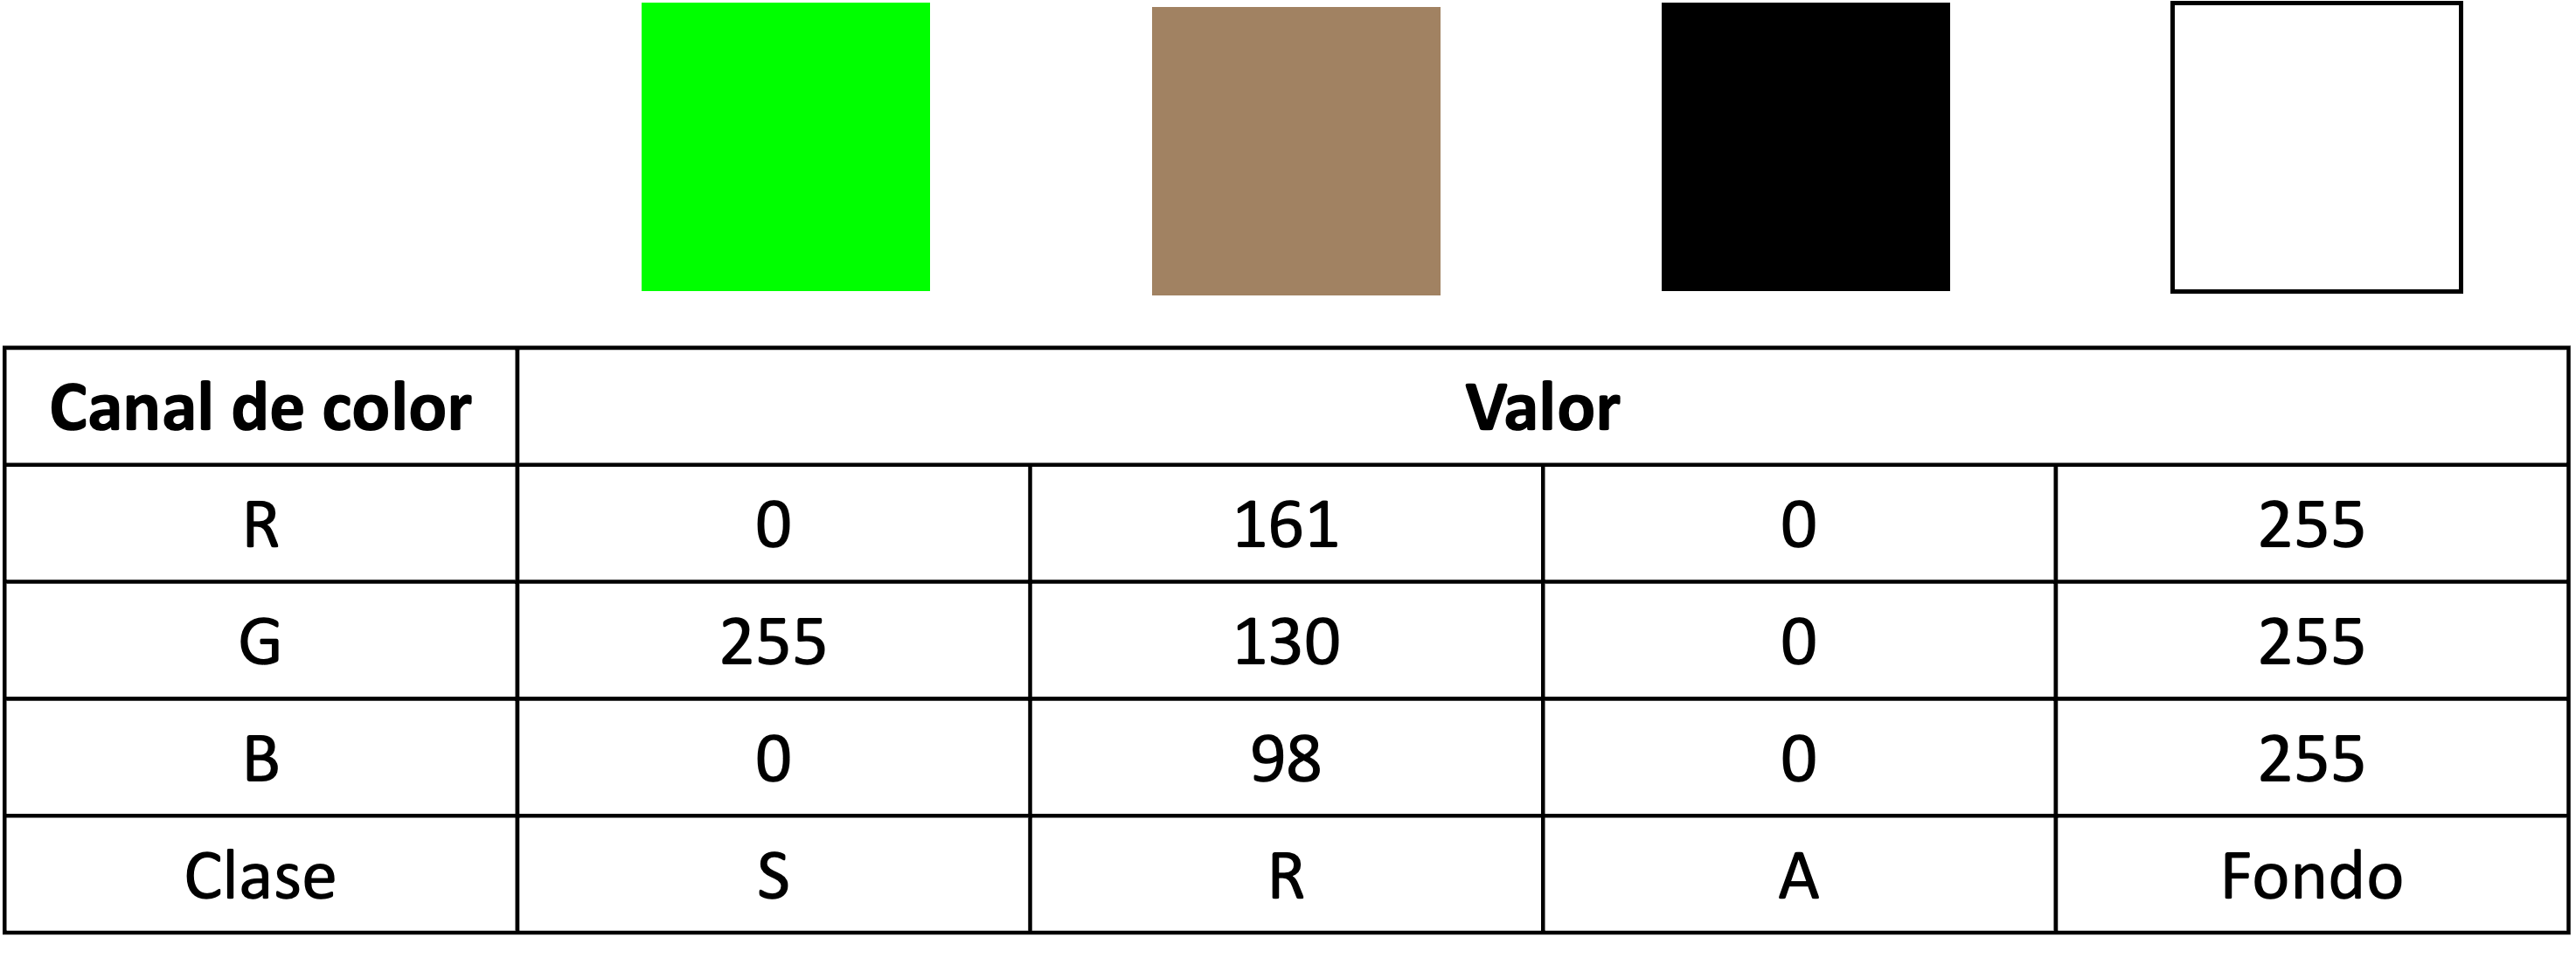 

## Figura 2. Código de colores utilizado para la clasificación de enfermedades

Finalmente, se obtienen las imágenes clasificadas.

Además, se calcularon las proporciones pertenecientes de cada clase; es decir, el total de pixeles clasificados como A, de S y de R; y su proporción de acuerdo al total de pixeles correspondientes al fruto. 

Todos esos valores se guardan en un archivo .csv que la función regresa.

### Ejecución del código

In [5]:
ruta_imagenes = "/Users/campos/Documents/COA 690/Segundo entrenamiento/Conjunto segmentado/"
ruta_etiquetas = "/Users/campos/Documents/COA 690/Segundo entrenamiento/Etiquetas prueba.csv"
id_img = lee_etiquetas(ruta_etiquetas)
csv = extension(id_img)

prueba = predice(ruta_imagenes, csv, 3)

prueba.to_csv("Clasificación CART MLP.csv")

Fruto con antracnosis
Fruto con antracnosis
Fruto con antracnosis
Fruto con antracnosis
Fruto con antracnosis
Fruto sano
Fruto sano
Fruto con antracnosis
Fruto con antracnosis
Fruto con antracnosis
Fruto con antracnosis
Fruto con antracnosis
Fruto con antracnosis
Fruto con antracnosis
Fruto con antracnosis
Fruto con roña
Fruto con roña
Fruto con roña
Fruto con roña
Fruto con roña
Fruto con roña
Fruto con roña
Fruto con roña
Fruto con roña
Fruto con roña
Fruto con roña
Fruto con roña
Fruto con roña
Fruto con roña
Fruto con roña
Fruto sano
Fruto sano
Fruto sano
Fruto con antracnosis
Fruto con antracnosis
Fruto con antracnosis
Fruto con antracnosis
Fruto sano
Fruto sano
Fruto sano
Fruto con antracnosis
Fruto con antracnosis
Fruto con antracnosis
Fruto sano
Fruto sano
Fruto con antracnosis
Fruto con antracnosis
Fruto sano
Fruto con antracnosis
Fruto con antracnosis
Fruto con antracnosis
Fruto con antracnosis
Fruto con antracnosis
Fruto sano
Fruto con antracnosis
Fruto con antracnosis
Fruto

Para ejecutar el código se definen los directorios donde se encuentra el lote de imágenes segmentadas, así como el archivo .csv que contiene las etiquetas.

Estos valores son los utilizados para la identificación que necesita la función `predice`, y para este caso, se utilizó al modelo MLP.

A continuación se muestra una imagen compuesta con algunos ejemplos identificados:

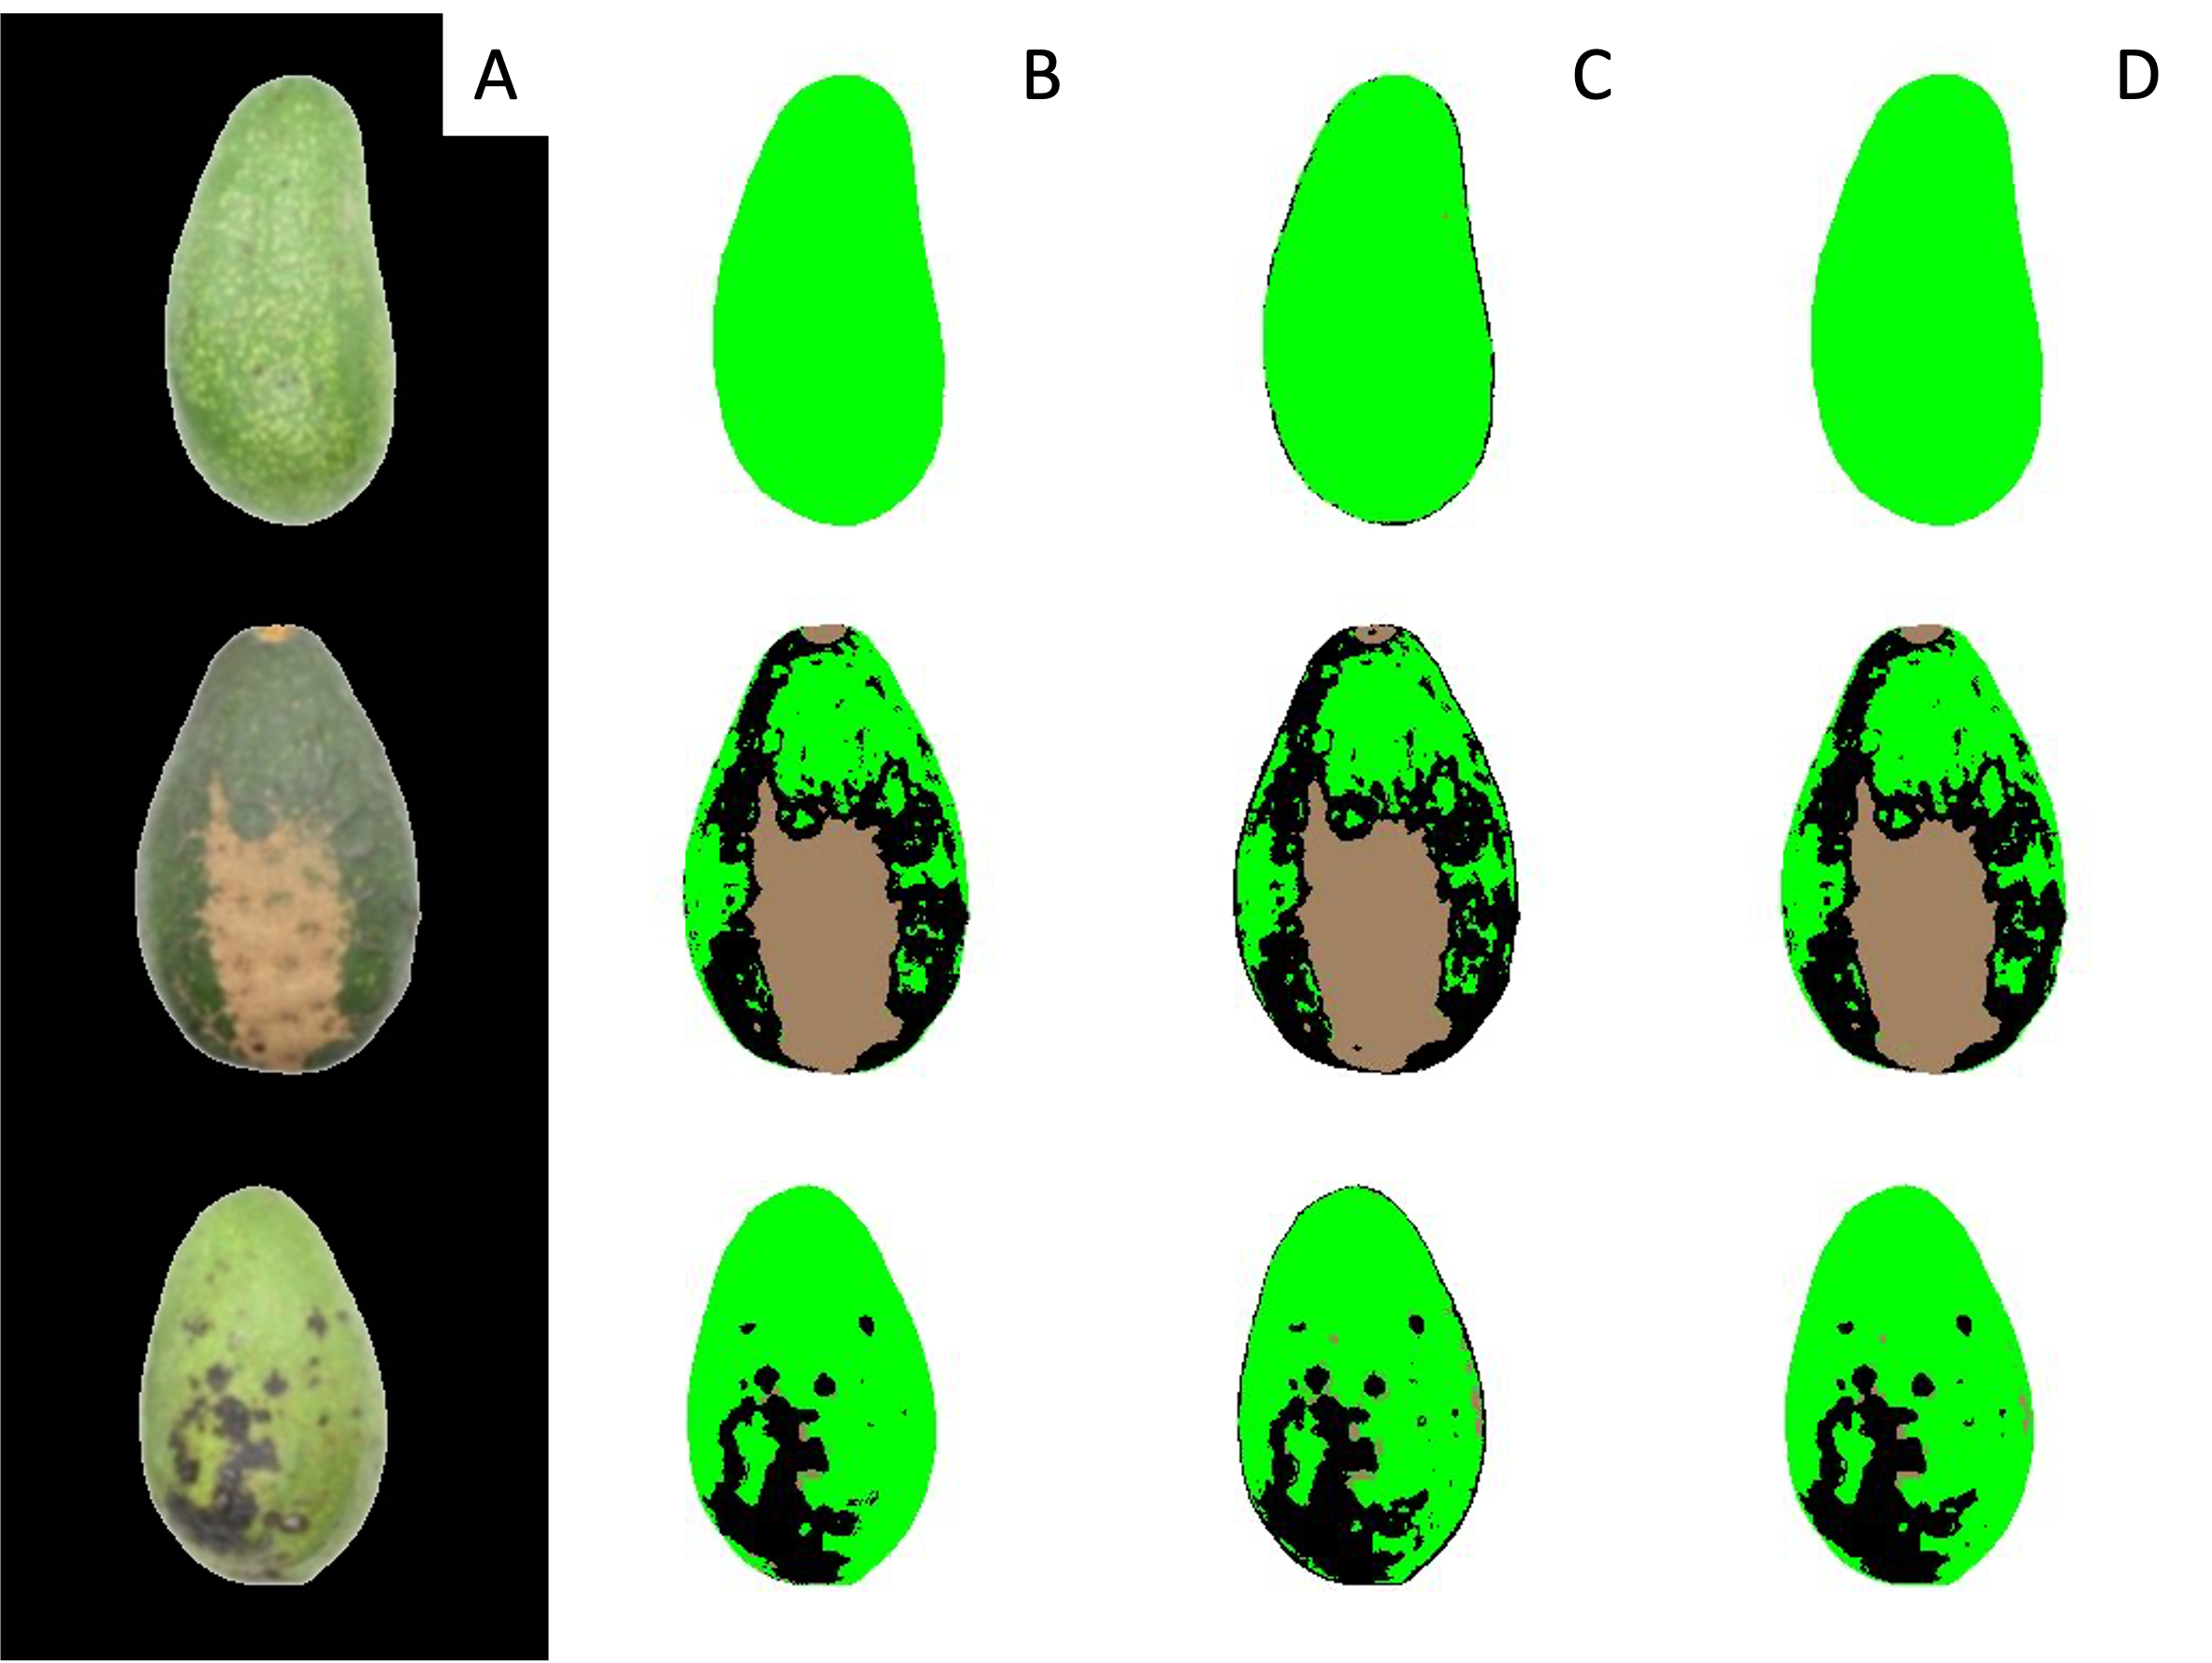

## Figura 3. Resultados de identificación para cada uno de los modelos. A. Imágenes segmentadas; B: Identificación con RF; C: Identificación con SVM; D: Identificación con MLP.

In [6]:
prueba.head()

,Archivo,Clase observada,Total Sanos,Porcentaje S,Total Ronia,Porcentaje R,Total Antracnosis,Porcentaje A,Clase predicha
0,Fruto 1.jpg,A,12529,75.64,194,1.17,3842,23.19,A
1,Fruto 2.jpg,A,10817,87.76,2,0.02,1506,12.22,A
2,Fruto 3.jpg,A,4805,74.15,2,0.03,1673,25.82,A
3,Fruto 4.jpg,A,7375,88.82,6,0.07,922,11.10,A
4,Fruto 5.jpg,A,4223,92.43,1,0.02,345,7.55,A


Como se puede obsservar, se agregó una nueva columna llamada "Clase predicha", que fue lo que el modelo predijo de acuerdo a las reglas de decisión del árbol CART.

Para saber qué proporción se obtuvo en predicción para cada clase, se definió la siguiente función.

In [7]:
def contador_clases (cuadro_salida):
    observado = []
    predicho = []
    c_A = 0
    c_R = 0
    c_S = 0
    
    for i in range (len(cuadro_salida)):
        observado.append(cuadro_salida["Clase observada"][i])
        predicho.append(cuadro_salida["Clase predicha"][i])
        
        if observado[i] == "A" and predicho[i] == "A":
            c_A = c_A + 1
        elif observado[i] == "R" and predicho[i] == "R":
            c_R = c_R + 1
        elif observado[i] == "S" and predicho[i] == "S":
            c_S = c_S + 1
    
    return c_A, c_R, c_S

Esta función simplemente comparará si lo que se tiene en Clase observada coincide con Clase predicha

In [9]:
conteo = contador_clases (prueba)
print(conteo)

(25, 30, 17)


Esto quiere decir que de las 30 imágenes por clase (90 en total), 25 fueron clasificadas correctamente para la clase A; 30 para roña y 17 para frutos sanos.